# Lecture : Recommendation on Graphs

## Lab 04 : Hybrid recommendation

### Xavier Bresson  


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/GML2023_codes/codes/05_Recommendation'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [2]:
# Load libraries
import numpy as np
import scipy.io
%matplotlib inline
#%matplotlib notebook 
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from IPython.display import display, clear_output
import time
import sys; sys.path.insert(0, 'lib/')
from lib.utils import shrink
from lib.utils import graph_laplacian
import scipy.sparse.linalg
import warnings; warnings.filterwarnings("ignore")


# Synthetic dataset 

In [6]:
# Load graphs of rows/users and columns/movies
mat = scipy.io.loadmat('datasets/synthetic_netflix.mat')
M = mat['M']
Otraining = mat['Otraining']
Otest = mat['Otest']
Wrow = mat['Wrow']
Wcol = mat['Wcol']
n,m = M.shape
print('n,m=',n,m)

Mgt = M # Ground truth
O = Otraining
M = O* Mgt
perc_obs_training = np.sum(Otraining) / (n*m)
print('perc_obs_training=',perc_obs_training)


n,m= 150 200
perc_obs_training= 0.03


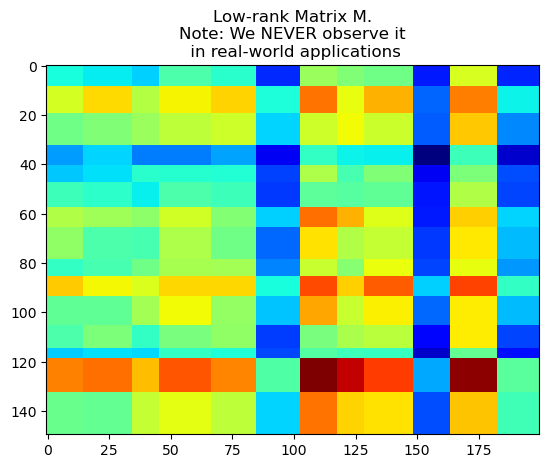

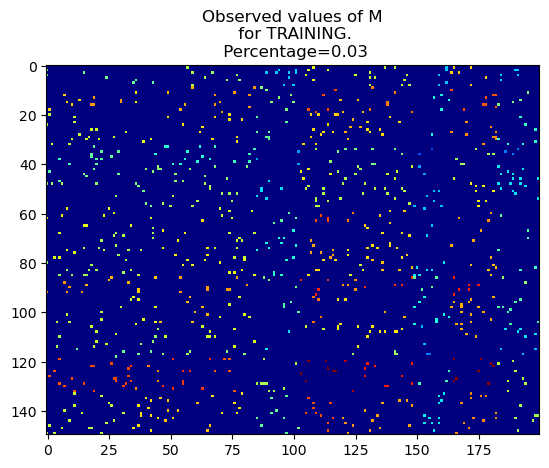

In [7]:
# Viusalize the rating matrix
plt.figure(1)
plt.imshow(Mgt, interpolation='nearest', cmap='jet')
plt.title('Low-rank Matrix M.\nNote: We NEVER observe it\n in real-world applications')
plt.show()

plt.figure(2)
plt.imshow(Otraining*Mgt, interpolation='nearest', cmap='jet')
plt.title('Observed values of M\n for TRAINING.\n Percentage=' + str(perc_obs_training))
plt.show()


Reconstruction Error: 112.68308


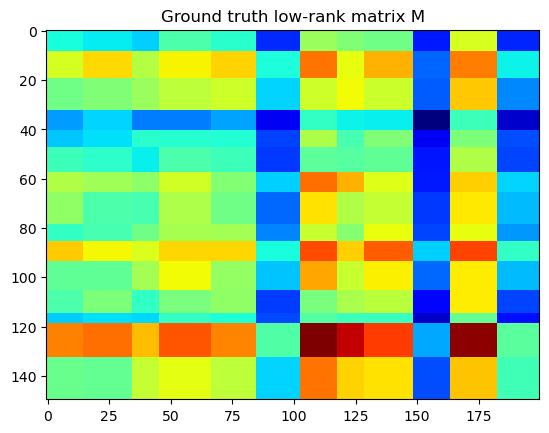

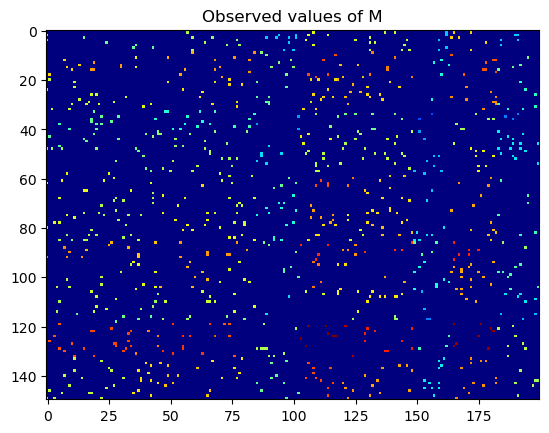

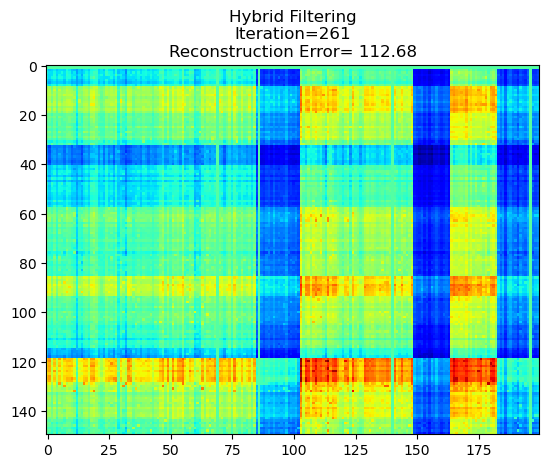

In [15]:
# Hybrid system : Matrix Completion on graphs

# Norm of the operator
OM = O*M
normOM = np.linalg.norm(OM,2)

#######################################
# Select the set of hyper-parameters
#######################################

# scenario : very low number of ratings, 0.03%, error metric = 112.68
lambdaDir = 1e-1 * 1e0; lambdaDF = 1e3; lambdaNuc = normOM/4; alpha = 0.1

#Compute Graph Laplacians
Lr = graph_laplacian(Wrow)
Lc = graph_laplacian(Wcol)
I = scipy.sparse.identity(m, dtype=Lr.dtype)
Lr = scipy.sparse.kron( I, Lr )
Lr = scipy.sparse.csr_matrix(Lr)
I = scipy.sparse.identity(n, dtype=Lc.dtype)
Lc = scipy.sparse.kron( Lc, I )
Lc = scipy.sparse.csr_matrix(Lc)

# Indentify zero columns and zero rows in the data matrix X
idx_zero_cols = np.where(np.sum(Otraining,axis=0)<1e-9)[0]
idx_zero_rows = np.where(np.sum(Otraining,axis=1)<1e-9)[0]
nb_zero_cols = len(idx_zero_cols)
nb_zero_rows = len(idx_zero_rows) 
 
# Pre-processing
L = alpha* Lc + (1.-alpha)* Lr 
vecO = np.reshape(O.T,[-1]) 
vecO = scipy.sparse.diags(vecO, 0, shape=(n*m, n*m) ,dtype=L.dtype)
vecO = scipy.sparse.csr_matrix(vecO) 
At = lambdaDir* L + lambdaDF* vecO 
vecM = np.reshape(M.T,[-1])
bt = lambdaDF* scipy.sparse.csr_matrix( vecM ).T
bt = np.array(bt.todense()).squeeze()
Id = scipy.sparse.identity(n*m)
Id = scipy.sparse.csr_matrix(Id) 

# Initialization
X = M; Xb = X;
Y = np.zeros([n,m])
normA = 1.
sigma = 1./normA
tau = 1./normA
diffX = 1e10
min_nm = np.min([n,m])
k = 0
while (k<2000) & (diffX>1e-1):
    
    # Update iteration
    k += 1
        
    # Update dual variable y
    Y = Y + sigma* Xb
    U,S,V = np.linalg.svd(Y/sigma) # % Y/sigma = U*S*V'
    Sdiag = shrink( S , lambdaNuc/ sigma )
    I = np.array(range(min_nm))
    Sshrink = np.zeros([n,m])
    Sshrink[I,I] = Sdiag
    Y = Y - sigma* U.dot(Sshrink.dot(V))    
    
    # Update primal variable x
    Xold = X
    X = X - tau* Y
    A = tau* At + Id
    vecX = np.reshape(X.T,[-1]) 
    vecX = scipy.sparse.csr_matrix(vecX) 
    b = tau* bt + vecX
    b = np.array(b).squeeze()    
    
    # Solve by linear system
    x,_ = scipy.sparse.linalg.cg(A, b, x0=b, tol=1e-6, maxiter=25)
    X = np.reshape(x,[m,n]).T
    # Fix issue with no observations along some rows and columns
    r,c = np.where(X>0.0); median = np.median(X[r,c])
    if nb_zero_cols>0: X[:,idx_zero_cols] = median
    if nb_zero_rows>0: X[nb_zero_rows,:] = median
        
    # Update primal variable xb
    Xb = 2.* X - Xold
        
    # Difference between two iterations
    diffX = np.linalg.norm(X-Xold)
        
    # Reconstruction error
    err_test = np.sqrt(np.sum((Otest*(X-Mgt))**2)) / np.sum(Otest) * (n*m)
    
    # Plot
    if not k%10:
        clear_output(wait=True)
        plt.figure(1)
        plt.imshow(X, interpolation='nearest', cmap='jet')
        plt.title('Hybrid Filtering\nIteration='+ str(k)+'\nReconstruction Error= '+ str(round(err_test,5)))
        plt.show()        
        print('diffX',diffX)


clear_output(wait=True) 
print('Reconstruction Error: '+ str(round(err_test,5)))

# Final plot
plt.figure(2)
plt.imshow(Mgt, interpolation='nearest', cmap='jet')
plt.title('Ground truth low-rank matrix M')

plt.figure(3)
plt.imshow(Otraining*Mgt, interpolation='nearest', cmap='jet')
plt.title('Observed values of M')

plt.figure(4)
plt.imshow(X, interpolation='nearest', cmap='jet')
plt.title('Hybrid Filtering\nIteration='+ str(k)+'\nReconstruction Error= '+ str(round(err_test,2)))
plt.show()



# Real-world dataset SWEETRS

In [16]:
# Load graphs of rows/users and columns/products
mat = scipy.io.loadmat('datasets/real_sweetrs_scenario1.mat')
mat = scipy.io.loadmat('datasets/real_sweetrs_scenario2.mat')
# mat = scipy.io.loadmat('datasets/real_sweetrs_scenario3.mat')
M = mat['M']
Otraining = mat['Otraining']
Otest = mat['Otest']
Wrow = mat['Wrow']
Wcol = mat['Wcol']
print('M', M.shape)
print('Otraining', Otraining.shape)
print('Otest', Otest.shape)
print('Wrow', Wrow.shape)
print('Wcol', Wcol.shape)

n,m = M.shape
print('n,m=',n,m)

Mgt = M # Ground truth
O = Otraining
M = O* Mgt
perc_obs_training = np.sum(Otraining)/(n*m)
print('perc_obs_training=',perc_obs_training)
perc_obs_test = np.sum(Otest) / (n*m)


M (664, 77)
Otraining (664, 77)
Otest (664, 77)
Wrow (664, 664)
Wcol (77, 77)
n,m= 664 77
perc_obs_training= 0.1317868878109842


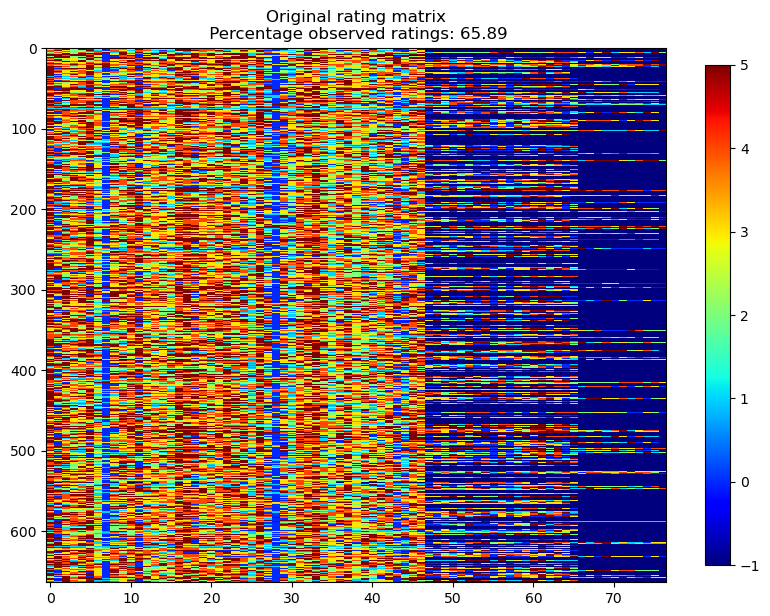

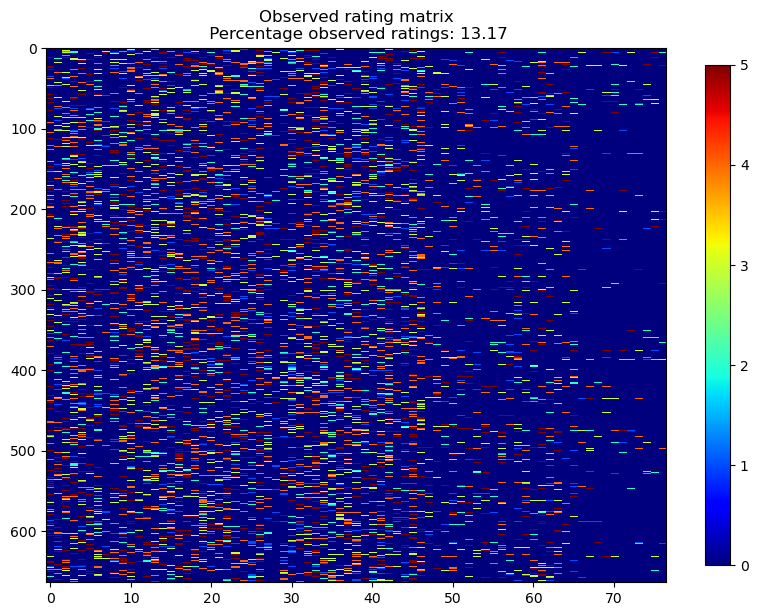

In [17]:
# Visualize the original rating matrix
plt.figure(1,figsize=(10,10))
plt.imshow(Mgt, interpolation='nearest', cmap='jet', aspect=0.1)
plt.colorbar(shrink=0.65)
plt.title('Original rating matrix\n Percentage observed ratings: ' + str(100*np.sum(Mgt>0)/(n*m))[:5])

# Visualize the observed rating matrix
plt.figure(2, figsize=(10,10))
plt.imshow(Otraining*Mgt, interpolation='nearest', cmap='jet', aspect=0.1)
plt.colorbar(shrink=0.65)
plt.title('Observed rating matrix\n Percentage observed ratings: ' + str(100*perc_obs_training)[:5])
plt.show()


Reconstruction Error: 397.4795


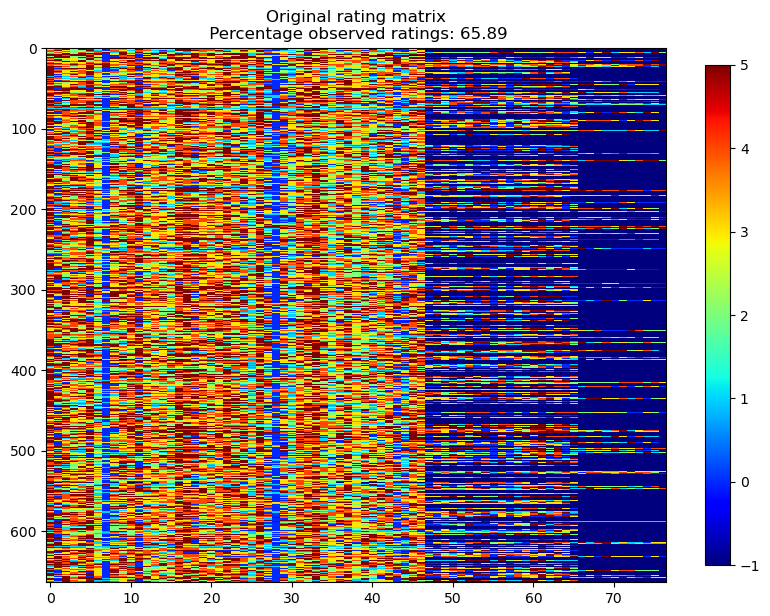

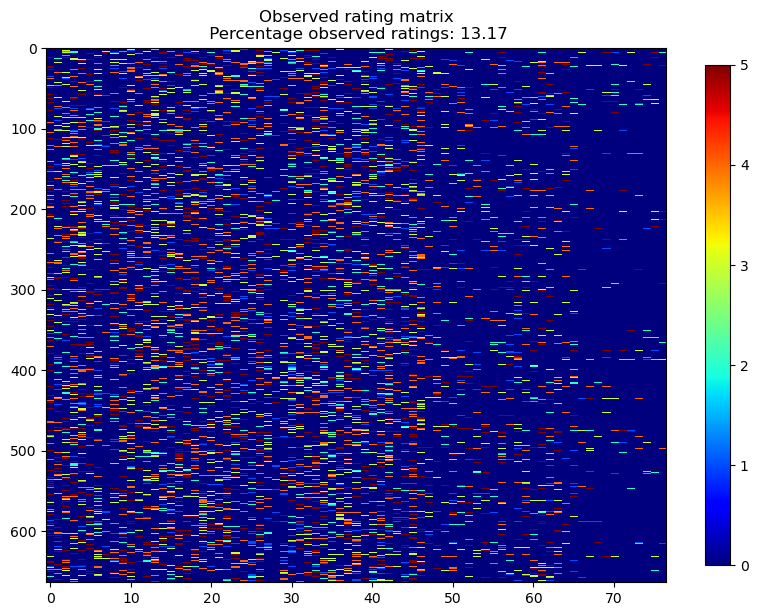

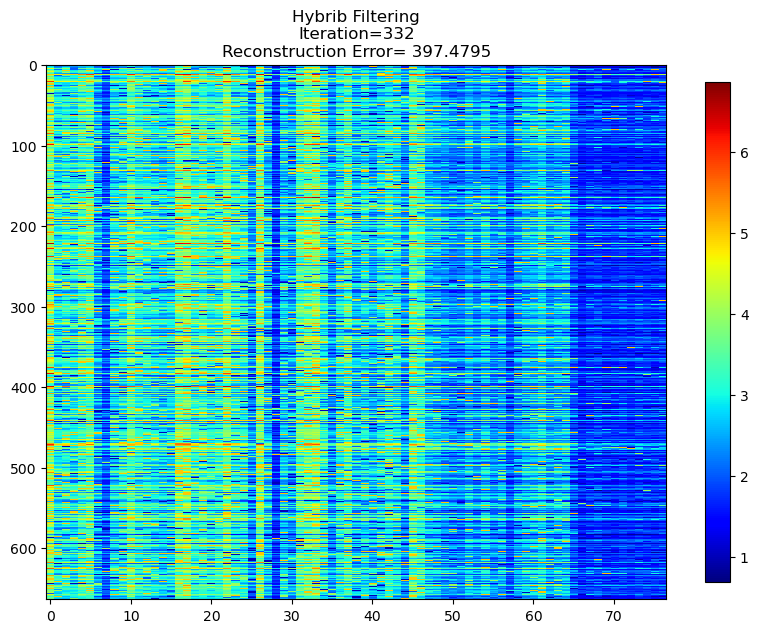

In [18]:
# Hybrid system : Matrix Completion on graphs

# Norm of the operator
OM = O*M
normOM = np.linalg.norm(OM,2)

#######################################
# Select the set of hyper-parameters
#######################################

# scenario 1 : low number of ratings, e.g. 1.3%, error metric = 402.71
lambdaDir = 1e-1 * 1e3 * 0.5; lambdaDF = 1e3; lambdaNuc = normOM/4; alpha = 0.02 

# # scenario 2 : intermediate number of ratings, e.g. 13.1%, error metric = 397.47
lambdaDir = 1e-1; lambdaDF = 1e3 * 10; lambdaNuc = normOM/4 /10; alpha = 0.25 

# # # scenario 3 : large number of ratings, e.g. 52.7%, error metric = 695.00
# lambdaDir = 1e-1 * 1e1; lambdaDF = 1e3; lambdaNuc = normOM/4; alpha = 0.02


#Compute Graph Laplacians
Lr = graph_laplacian(Wrow)
Lc = graph_laplacian(Wcol)
I = scipy.sparse.identity(m, dtype=Lr.dtype)
Lr = scipy.sparse.kron( I, Lr )
Lr = scipy.sparse.csr_matrix(Lr)
I = scipy.sparse.identity(n, dtype=Lc.dtype)
Lc = scipy.sparse.kron( Lc, I )
Lc = scipy.sparse.csr_matrix(Lc)

# Indentify zero columns and zero rows in the data matrix X
idx_zero_cols = np.where(np.sum(Otraining,axis=0)<1e-9)[0]
idx_zero_rows = np.where(np.sum(Otraining,axis=1)<1e-9)[0]
nb_zero_cols = len(idx_zero_cols)
nb_zero_rows = len(idx_zero_rows)

# Pre-processing
L = alpha* Lc + (1.-alpha)* Lr 
vecO = np.reshape(O.T,[-1]) 
vecO = scipy.sparse.diags(vecO, 0, shape=(n*m, n*m) ,dtype=L.dtype)
vecO = scipy.sparse.csr_matrix(vecO) 
At = lambdaDir* L + lambdaDF* vecO 
vecM = np.reshape(M.T,[-1])
bt = lambdaDF* scipy.sparse.csr_matrix( vecM ).T
bt = np.array(bt.todense()).squeeze()
Id = scipy.sparse.identity(n*m)
Id = scipy.sparse.csr_matrix(Id) 

# Initialization
X = M; Xb = X;
Y = np.zeros([n,m])
normA = 1.
sigma = 1./normA
tau = 1./normA
diffX = 1e10
min_nm = np.min([n,m])
k = 0
while (k<2000) & (diffX>1e-1):
    
    # Update iteration
    k += 1
        
    # Update dual variable y
    Y = Y + sigma* Xb
    U,S,V = np.linalg.svd(Y/sigma) # % Y/sigma = U*S*V'
    Sdiag = shrink( S , lambdaNuc/ sigma )
    I = np.array(range(min_nm))
    Sshrink = np.zeros([n,m])
    Sshrink[I,I] = Sdiag
    Y = Y - sigma* U.dot(Sshrink.dot(V))    
    
    # Update primal variable x
    Xold = X
    X = X - tau* Y
    A = tau* At + Id
    vecX = np.reshape(X.T,[-1]) 
    vecX = scipy.sparse.csr_matrix(vecX) 
    b = tau* bt + vecX
    b = np.array(b).squeeze()    
    
    # Solve by linear system
    x,_ = scipy.sparse.linalg.cg(A, b, x0=b, tol=1e-6, maxiter=25)
    X = np.reshape(x,[m,n]).T
    # Fix issue with no observations along some rows and columns
    r,c = np.where(X>0.0); median = np.median(X[r,c])
    if nb_zero_cols>0: X[:,idx_zero_cols] = median
    if nb_zero_rows>0: X[nb_zero_rows,:] = median
        
    # Update primal variable xb
    Xb = 2.* X - Xold
        
    # Difference between two iterations
    diffX = np.linalg.norm(X-Xold)
        
    # Reconstruction error
    err_test = np.sqrt(np.sum((Otest*(X-Mgt))**2)) / np.sum(Otest) * (n*m)
    
    # Plot
    if not k%10:
        clear_output(wait=True)   
        plt.figure(figsize=(10,10))
        plt.imshow(X, interpolation='nearest', cmap='jet', aspect=0.1)
        plt.colorbar(shrink=0.65)
        plt.title('Hybrib Filtering\nIteration='+ str(k)+'\nReconstruction Error= '+ str(round(err_test,5)))
        plt.show()
        print('diffX',diffX)

clear_output(wait=True) 
print('Reconstruction Error: '+ str(round(err_test,5)))

# Final plots
plt.figure(2, figsize=(10,10))
plt.imshow(Mgt, interpolation='nearest', cmap='jet', aspect=0.1)
plt.colorbar(shrink=0.65)
plt.title('Original rating matrix\n Percentage observed ratings: ' + str(100*np.sum(Mgt>0)/(n*m))[:5])
plt.show()

plt.figure(3, figsize=(10,10))
plt.imshow(Otraining*Mgt, interpolation='nearest', cmap='jet', aspect=0.1)
plt.colorbar(shrink=0.65)
plt.title('Observed rating matrix\n Percentage observed ratings: ' + str(100*perc_obs_training)[:5])
plt.show()

plt.figure(4, figsize=(10,10))
plt.imshow(X, interpolation='nearest', cmap='jet', aspect=0.1)
plt.colorbar(shrink=0.65)
plt.title('Hybrib Filtering\nIteration='+ str(k)+'\nReconstruction Error= '+ str(round(err_test,5)))
plt.show()

